# Data Analysis and Visualization of Retail Sales

We have preliminarily processed and cleaned the data so we can now proceed with our exploratory data analysis. Based on the results of our analysis, we may either proceed to modeling or further perform some data processing and cleaning as shown in the diagram below.

![Milestone 2](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/project1_milestone2.png)

This part involves three tasks:

1. Analyze and visualize retail sales by weekday, month and year
2. Determine seasonality
3. Train-test split data for model ingestion

## Importing Necessary Libraries and Functions

The data (data/sales_processed.csv) that we are using is an output from part 1.

<ins>Instruction</ins>:<br>
- We have written the code to import the libraries so you can just run it. If you need other libraries while working on this notebook, please feel free to add the library to this cell below.

In [18]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
if RunningInCOLAB:
  !pip install plotly==5.2.1  # Do restart runtime when prompted if you are running this in Colab
import plotly.express as px
from scipy import signal
from scipy.signal import savgol_filter

np.seterr(divide='ignore')

%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

## Initial Data Exploration

<ins>Instructions</ins>:<br>
- Read in the data *sales_processed.csv* from the data folder into a pandas dataframe and preview the first 5 rows. Set the `date` column to dateime format.

In [19]:
if RunningInCOLAB:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving sales_processed.csv to sales_processed (1).csv
User uploaded file "sales_processed.csv" with length 1923833 bytes


In [20]:
# read in our processed data
# by using parse_dates in parameter of read_csv, we can convert date column to datetime format without additional step
if RunningInCOLAB:
  sales_df = pd.read_csv('./sales_processed.csv', parse_dates=['date'])
else:
  sales_df = pd.read_csv('../data/sales_processed.csv', parse_dates=['date'])  # use this if running notebook in local 
sales_df.info()
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   store_id  58230 non-null  object        
 1   cat_id    58230 non-null  object        
 2   date      58230 non-null  datetime64[ns]
 3   sales     58230 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.8+ MB


,store_id,cat_id,date,sales
0,TX_1,FOODS,2011-01-29,3950.35
1,TX_1,FOODS,2011-01-30,3844.97
2,TX_1,FOODS,2011-01-31,2888.03
3,TX_1,FOODS,2011-02-01,3631.28
4,TX_1,FOODS,2011-02-02,3072.18


As a start, let's try to visualize our time series data. Remember we have multiple time series with each series being sales by store and category. So we need to plot each of these series as separate lines. Rather than plotting individual line charts, let's plot them all on same plot so that we can also compare across series.

<ins>Instructions</ins>:<br>
- Plot line charts of each time series in the same diagram.

<ins>Hints</ins>: 
- [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

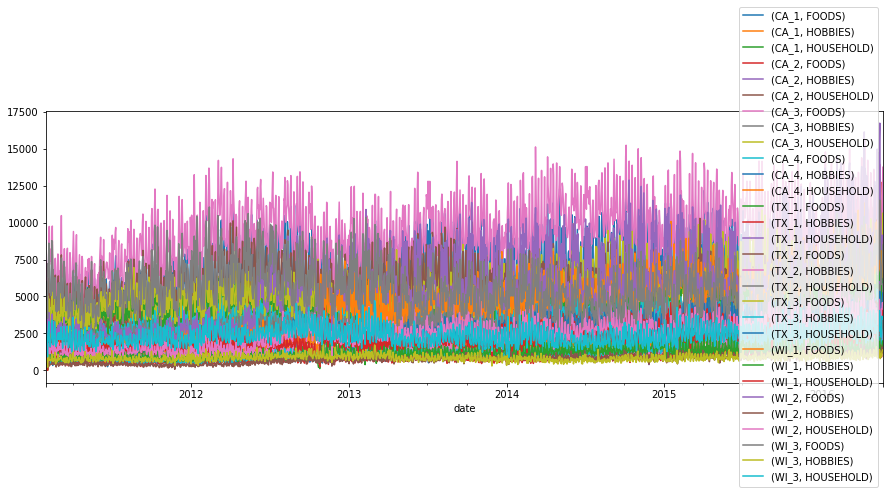

In [21]:
sales_df_plot = sales_df.set_index('date')
# plot line chart by group
_ = sales_df_plot.groupby(['store_id', 'cat_id'])['sales'].plot(figsize=(15,5), legend=True)
_ = plt.legend(loc='right')

Oops! Ok that did not work well... Let's reduce the number of series in a plot by filtering by category and plot an interactive plot for easy toggling. Below, we plotted a Plotly diagram where one can click on the variable in the legend to toggle the time series on or off. We can also zoom into a section of the plot by click dragging a box around that particular section.

<ins>Instructions</ins>:<br>
- Plot line charts of the same category in a plotly diagram
- Play around with the diagrams and analyse the time series

<ins>Hints</ins>: 
- We leveraged on the code from Plotly documentation [here](https://plotly.com/python/time-series/#configuring-tick-labels).

In [22]:
def show_sales(df, category):
    """
    Plot interactive line charts of sales
    """
    sales_df_transformed = pd.pivot_table(df.loc[df.cat_id==category], values='sales', index=['date'], columns=['store_id', 'cat_id'])
    sales_df_transformed.reset_index(inplace=True)
    sales_df_transformed.columns = [' '.join(col).strip() for col in sales_df_transformed.columns.values]

    fig = px.line(sales_df_transformed, x="date", y=sales_df_transformed.columns,
                  hover_data={"date": "|%B %d, %Y"},
                  title='Daily Retail Sales by Store and Category')
    fig.update_xaxes(
        dtick="M1",
        tickformat="%b\n%Y")
    fig.show()

# plot for FOODS category
show_sales(sales_df, 'FOODS')

In [23]:
show_sales(sales_df, 'HOBBIES')

In [24]:
show_sales(sales_df, 'HOUSEHOLD')

From our Plotly diagrams, we can see that there are some time series which have abrupt breaks in trend. These breaks will not be helpful for our modeling later so we should remove the past data before the breaks.

![Trend Break](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/trend_break.PNG)

<ins>Instructions</ins>:<br>
- Identify the time series with breaks in trend
- Remove the past data before the breaks from these time series
- Save the output as `sales_cleaned.csv` in the data folder

In [25]:
sales_df_clean = sales_df.copy()
sales_df_clean['series_id'] = sales_df_clean['store_id'] + '_' + sales_df_clean['cat_id']
# set indicator to mark data points to drop
sales_df_clean['drop_ind'] = ((sales_df_clean.series_id=='CA_2_FOODS') & (sales_df_clean.date < '2015-06-01')) | \
                            ((sales_df_clean.series_id=='WI_1_FOODS') & (sales_df_clean.date < '2012-11-01')) | \
                            ((sales_df_clean.series_id=='WI_2_FOODS') & (sales_df_clean.date < '2012-06-01')) | \
                            ((sales_df_clean.series_id=='WI_1_HOUSEHOLD') & (sales_df_clean.date < '2012-11-01')) | \
                            ((sales_df_clean.series_id=='WI_2_HOUSEHOLD') & (sales_df_clean.date < '2012-06-01'))

# drop the data points identified as past data before trend breaks
sales_df_clean = sales_df_clean.loc[sales_df_clean.drop_ind==False]
sales_df_clean.drop(columns=['drop_ind'], inplace=True)
sales_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54384 entries, 0 to 58229
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   store_id   54384 non-null  object        
 1   cat_id     54384 non-null  object        
 2   date       54384 non-null  datetime64[ns]
 3   sales      54384 non-null  float64       
 4   series_id  54384 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.5+ MB


In [26]:
# save output to sales_cleaned.csv
if RunningInCOLAB:
  sales_df_clean.to_csv('./sales_cleaned.csv', index=False)
else:
  # use this if running in local
  sales_df_clean.to_csv('../data/sales_cleaned.csv', index=False)

Now that we have our sales data cleaned up, we can analyse the sales data again in detail. Specifically, we are going to analyze and visualize the retail sales by weekday, month and year, or in other words, find out the trend and seasonality patterns.

<ins>Instructions</ins>:<br>
- Choose a random `store_id` and `cat_id` to analyse the time series
- Plot the box plots of the sales by weekday, day of month, and month separately
- Plot line charts of sales by weekday, day of month, and month separately by year

<ins>Hints</ins>: 
- Use the diagrams below as a reference for your plots.

![Seasonality plots](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/seasonality_pattern_plots.PNG)

In [27]:
# filter for a time series
store = 'TX_1'
category = 'FOODS'
sales_series_df_plot = sales_df_clean.loc[(sales_df_clean.store_id==store) & (sales_df_clean.cat_id==category)]

Text(0.5, 0, 'month')

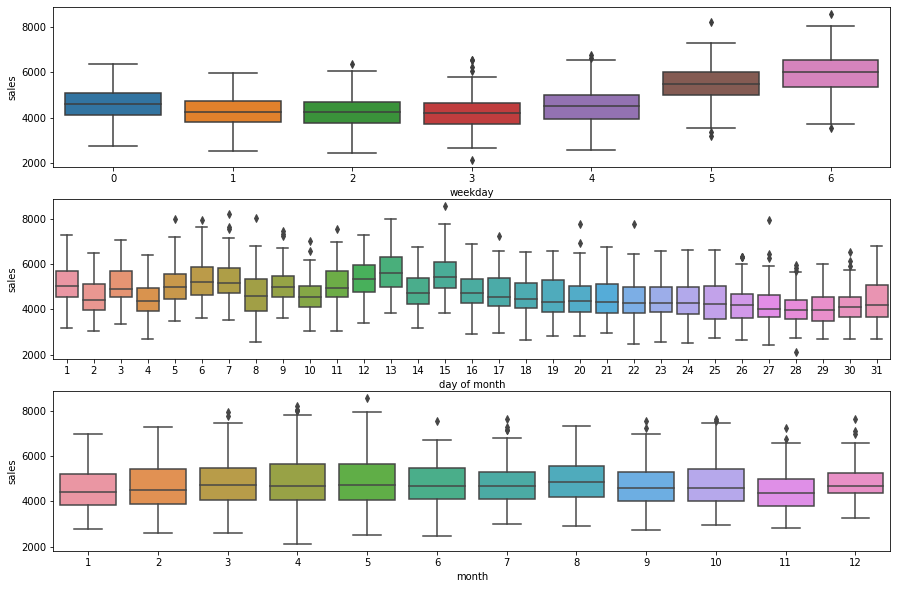

In [28]:
# box plots by weekday, day of month, and month
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
sns.boxplot(x=sales_series_df_plot.date.dt.weekday, y=sales_series_df_plot.sales, ax=ax[0])
sns.boxplot(x=sales_series_df_plot.date.dt.day, y=sales_series_df_plot.sales, ax=ax[1])
sns.boxplot(x=sales_series_df_plot.date.dt.month, y=sales_series_df_plot.sales, ax=ax[2])

ax[0].set_xlabel('weekday')
ax[1].set_xlabel('day of month')
ax[2].set_xlabel('month')

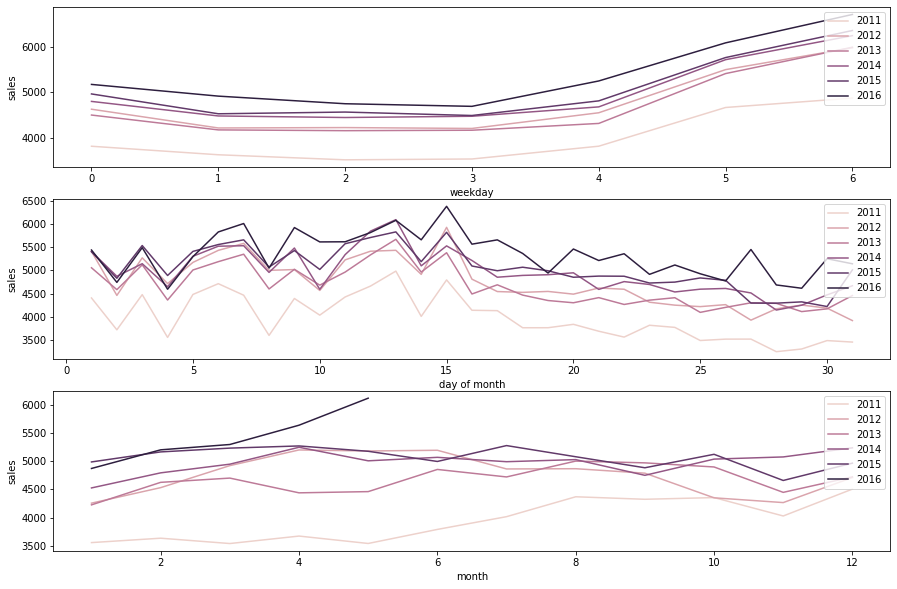

In [29]:
# line charts by weekday, day of month, and month, group by year
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))

sns.lineplot(x=sales_series_df_plot.date.dt.weekday, y=sales_series_df_plot.sales, hue=sales_series_df_plot.date.dt.year, ax=ax[0], ci=None)
sns.lineplot(x=sales_series_df_plot.date.dt.day, y=sales_series_df_plot.sales, hue=sales_series_df_plot.date.dt.year, ax=ax[1], ci=None)
sns.lineplot(x=sales_series_df_plot.date.dt.month, y=sales_series_df_plot.sales, hue=sales_series_df_plot.date.dt.year, ax=ax[2], ci=None)

ax[0].set_xlabel('weekday')
ax[1].set_xlabel('day of month')
ax[2].set_xlabel('month')

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
ax[2].legend(loc="upper right")

From our plots, we can clearly see a strong weekday pattern and some monthly seasonality: 
- Sales tend to be higher on Friday and weekends
- Mid of the month spike in sales followed by a trend downwards for rest of month
- No obvious yearly seasonality

Besides using plots, is there a more objective way of determining seasonality? This is what we will investigate in the next section below.

## Determine Seasonality

Let's now have a more objective way of determining seasonality. We do this via a periodogram.

You can read up more about what is a periodogram over [here](https://online.stat.psu.edu/stat510/lesson/6/6.1#paragraph--356). But in a nutshell, a time series can be viewed as a composition of repeating waves of various amplitude and frequency, and the peridogram shows the possible frequency values that are important in describing the oscillating pattern of the time series. Thus, if there is a seasonality pattern that repeats itself, the periodogram will be able to capture that.

Without further ado, let's plot our periodogram.

<ins>Instructions</ins>:<br>
- Detrend the time series before using the periodogram so as to give more accurate results as mentioned by [this online university resource notes](https://online.stat.psu.edu/stat510/lesson/6/6.1#paragraph--360)
- Set up a periodogram using [Scipy's periodogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html)
- Plot a periodogram and identify the main seasonality pattern(s)

<ins>Hints</ins>: 
- The frequency values from periodogram can be inverted (i.e., 1/freq) to get the time interval values.

In [30]:
def detrend_series(store, category):
    """
    Detrend the sales of a time series and return the detrended sales value, 
    the trend identified, and the original sales 
    """
    df_series = sales_df.loc[(sales_df.store_id==store) & (sales_df.cat_id==category)]
    # savgol_filter is used to better detrend sales. Alternatively can use scipy detrend 
    data_trend = savgol_filter(df_series['sales'].values,365,1)
    data_detrended = (df_series['sales'] - data_trend).values
    return data_detrended, data_trend, df_series

def summarise_periodicity(data_detrended):
    """
    Extract important frequency values with periodogram
    """
    f, Periodogram = signal.periodogram(data_detrended)
    # Make dataframe for finding frequency with highest power spectrum
    data = {'interval':1/f, 'power_spectral_density':Periodogram}
    df_periodogram = pd.DataFrame(data = data)
    df_periodogram.sort_values(by=['power_spectral_density'], ascending=False, inplace=True)
    return df_periodogram[:3] # retrieve top three frequency values

def plot_series_trend(df_series, data_trend, data_detrended):
    """
    Plot original and detrended sales of time series 
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(df_series['date'].values, df_series['sales'].values)
    ax[0].plot(df_series['date'].values, data_trend)
    ax[1].plot(df_series['date'].values, data_detrended)
    ax[0].title.set_text('Sales with trend line')
    ax[1].title.set_text('Sales detrended')
    ax[0].set_ylabel('Sales')
    plt.show()

def plot_periodicity(data_detrended):
    """
    Plot periodogram
    """
    f, Periodogram = signal.periodogram(data_detrended)
    plt.plot(f, Periodogram)
    plt.title("Periodogram")
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectrum')
    plt.show()

After sampling a few time series and analysing the periodograms, we can see that there are generally 2-3 significant frequency values. One of them has an especially large power spectral density compared to the other frequency values. We can guess that this is probably the weekly seasonality based on our earlier analysis of the plots.

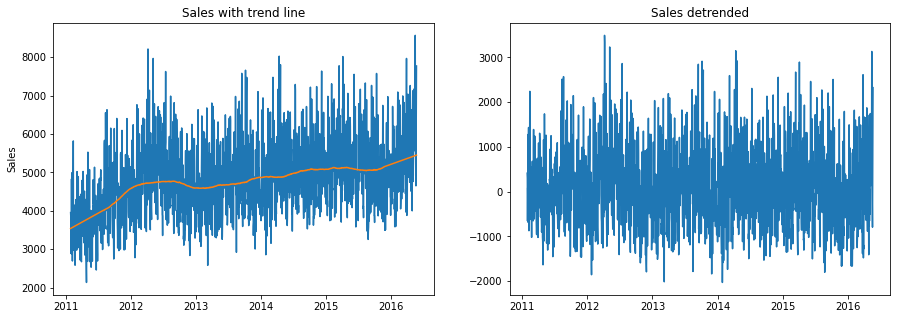

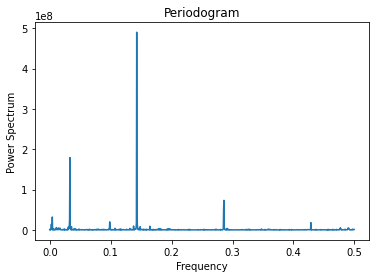

In [31]:
store = 'TX_1'
category = 'FOODS'
data_detrended, data_trend, df_series = detrend_series(store, category)

# plot time series original and detrended sales
plot_series_trend(df_series, data_trend, data_detrended)

# plot periodogram
plot_periodicity(data_detrended)

As frequency values probably do not make sense to us, we can invert them to obtain the time interval values. By filtering the top 3 frequency values for each time series and summarising the counts of the time intervals, we are able to clearly identify the weekly (time interval 7) and monthly seasonalities (time interval 30). We can ignore the rest of the time intervals that are not as frequently occurring. Interestingly, time interval 3 is frequently occurring and we can perhaps interpret it as half-weekly seasonality.

In [32]:
periodogram_list = []

for store in sales_df.store_id.unique():
    for category in sales_df.cat_id.unique():
        data_detrended, data_trend, df_series = detrend_series(store, category)
        periodicity_df = summarise_periodicity(data_detrended)
        periodogram_list.append(periodicity_df)

periodogram_df = pd.concat(periodogram_list)
periodogram_df['interval'] = periodogram_df['interval'].round(0).astype(int)
periodogram_df.sort_values(by='power_spectral_density', ascending=False, inplace=True)
periodogram_df.interval.value_counts()

7      57
3      12
30     11
323     4
31      2
4       2
243     1
277     1
Name: interval, dtype: int64

Having analyzed our time series, we are now ready to proceed to our last step before moving on to modeling in the next Milestone.

## Train-Test Split

In order to measure the performance of our models on unseen data, train-test split is a very important technique to implement before modeling. We can use [cross validation](https://otexts.com/fpp3/tscv.html), a sophisticated form of train-test split, to evaluate our models more accurately.

For time series, we will also need to take in consideration the temporal interdependence.

In our case, we will be implementing a nested walk-forward validation.

![Nested Walk-Forward Validation](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/walk_forward_validation.png)

For our hyperparameter tuning, we will train on the training data and evaluate on the validation data in each split. Based on the average model score across the splits, we choose the optimal hyperparameters.

Then using the optimal hyperparameters, we will train on both the training and validation data, and evaluate on the test data in each split. The average model score will be our final score for the model.

Let's implement our train-test split now.

<ins>Instructions</ins>:<br>
- Code a function that implements train-test split given a cross-validation split number and returns the split's training, validation and test data. Since we are required to forecast for the next 28 days, we can set 28 days as the period for test and validation data. 

In [33]:
def get_cv_split(df, split_num, prediction_length=28, validation=True):
    """
    Implement train-test split given a cv split number and return training, val and test data
    """
    if 'series_id' not in df.columns:
        df['series_id'] = df['store_id'] + '_' + df['cat_id']
    series_list = df['series_id'].unique()

    test_list = []
    validation_list = []
    training_list = []

    for series in series_list:
        df_series = df.loc[df.series_id==series]
        max_date = df_series.date.max()
        min_date = df_series.date.min()
        test_lower_date = max_date - pd.Timedelta(f"{prediction_length*((split_num+1)*2-1)} days")
        test_upper_date = max_date - pd.Timedelta(f"{prediction_length*(split_num*2)} days")
        val_lower_date = max_date - pd.Timedelta(f"{prediction_length*(split_num+1)*2} days")
        if min(test_lower_date, test_upper_date) < min_date:
            raise Exception("Insufficient data for splitting")

        df_series_test = df_series.loc[(df_series.date > test_lower_date) & (df_series.date <= test_upper_date)]
        if validation:
            df_series_val = df_series.loc[(df_series.date > val_lower_date) & (df_series.date <= test_lower_date)]
            df_series_train = df_series.loc[df_series.date <= val_lower_date]
        else:
            df_series_val = pd.DataFrame()
            df_series_train = df_series.loc[df_series.date <= test_lower_date]
        test_list.append(df_series_test)
        validation_list.append(df_series_val)
        training_list.append(df_series_train)

    test_df = pd.concat(test_list)
    validation_df = pd.concat(validation_list)
    training_df = pd.concat(training_list)
    return training_df, validation_df, test_df

We can do some quick checks to see that our train-test function does work as expected:
- No overlap in time period
- 28 days in each test and validation data

In [34]:
training_df, validation_df, test_df = get_cv_split(sales_df_clean, 0, validation=True)
print(f"Test data is from {test_df.date.min()} to {test_df.date.max()}")
print(f"Validation data is from {validation_df.date.min()} to {validation_df.date.max()}")
print(f"Training data is till {training_df.date.max()}")

Test data is from 2016-04-25 00:00:00 to 2016-05-22 00:00:00
Validation data is from 2016-03-28 00:00:00 to 2016-04-24 00:00:00
Training data is till 2016-03-27 00:00:00


In [35]:
print(f"Test data consists of {len(test_df.loc[test_df.series_id=='TX_1_FOODS'])} days")
print(f"Validation data consists of {len(validation_df.loc[validation_df.series_id=='TX_1_FOODS'])} days")

Test data consists of 28 days
Validation data consists of 28 days


With the analysis and train-test split function done, we are now ready to move on to modeling in our next final Milestone. Good job!